## Import library

In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset dan dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 64
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data_wildfire/Training/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data_wildfire/Testing/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [4]:
feature , target = next(iter(trainloader))
feature.shape

torch.Size([64, 3, 64, 64])

In [5]:
label2cat = train_set.classes 
label2cat

['fire', 'nofire']

## Arsitektur dan config

In [6]:
from jcopdl.layers import conv_block, linear_block

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 6),
            conv_block(6, 12),
            conv_block(12, 24),
            conv_block(24, 48),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            linear_block(768, 256),
            linear_block(256, 2, activation='lsoftmax')
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [8]:
48 * 4 * 4

768

In [9]:
config = ({
    "batch_size":bs,
    "crop_size":crop_size
})

## Training Preparation

In [10]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir="model")

## Training Loop

In [11]:
from tqdm.auto import tqdm

In [12]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.5837 | Test_cost  = 0.4430 | Train_score = 0.6807 | Test_score = 0.8382 |




Epoch     2
Train_cost  = 0.3079 | Test_cost  = 0.4609 | Train_score = 0.8794 | Test_score = 0.8235 |
==> EarlyStop patience =  1 | Best test_score: 0.8382




Epoch     3
Train_cost  = 0.2158 | Test_cost  = 0.3150 | Train_score = 0.9192 | Test_score = 0.8971 |




Epoch     4
Train_cost  = 0.1641 | Test_cost  = 0.3260 | Train_score = 0.9438 | Test_score = 0.9412 |




Epoch     5
Train_cost  = 0.1653 | Test_cost  = 0.2595 | Train_score = 0.9410 | Test_score = 0.9118 |
==> EarlyStop patience =  1 | Best test_score: 0.9412




Epoch     6
Train_cost  = 0.1577 | Test_cost  = 0.2368 | Train_score = 0.9471 | Test_score = 0.9265 |
==> EarlyStop patience =  2 | Best test_score: 0.9412




Epoch     7
Train_cost  = 0.1123 | Test_cost  = 0.2044 | Train_score = 0.9634 | Test_score = 0.9559 |




Epoch     8
Train_cost  = 0.1213 | Test_cost  = 0.1448 | Train_score = 0.9558 | Test_score = 0.9412 |
==> EarlyStop patience =  1 | Best test_score: 0.9559




Epoch     9
Train_cost  = 0.1159 | Test_cost  = 0.1415 | Train_score = 0.9596 | Test_score = 0.9412 |
==> EarlyStop patience =  2 | Best test_score: 0.9559




Epoch    10
Train_cost  = 0.0968 | Test_cost  = 0.1448 | Train_score = 0.9662 | Test_score = 0.9559 |
==> EarlyStop patience =  3 | Best test_score: 0.9559




Epoch    11
Train_cost  = 0.0975 | Test_cost  = 0.1893 | Train_score = 0.9662 | Test_score = 0.9118 |
==> EarlyStop patience =  4 | Best test_score: 0.9559




Epoch    12
Train_cost  = 0.1033 | Test_cost  = 0.2422 | Train_score = 0.9602 | Test_score = 0.9265 |
==> EarlyStop patience =  5 | Best test_score: 0.9559
==> Execute Early Stopping at epoch: 12 | Best test_score: 0.9559
==> Best model is saved at model


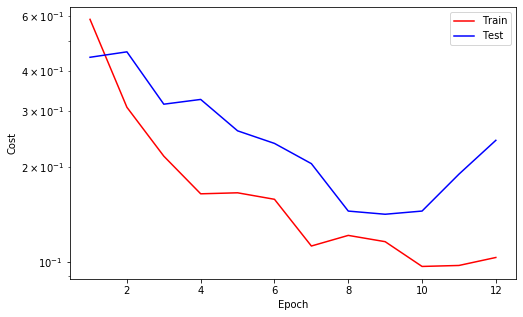

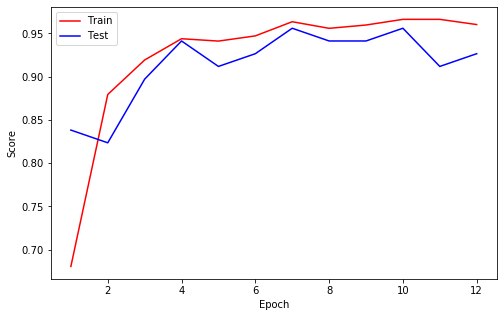

In [13]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
            test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [14]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [15]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0])

In [16]:
import matplotlib.pyplot as plt

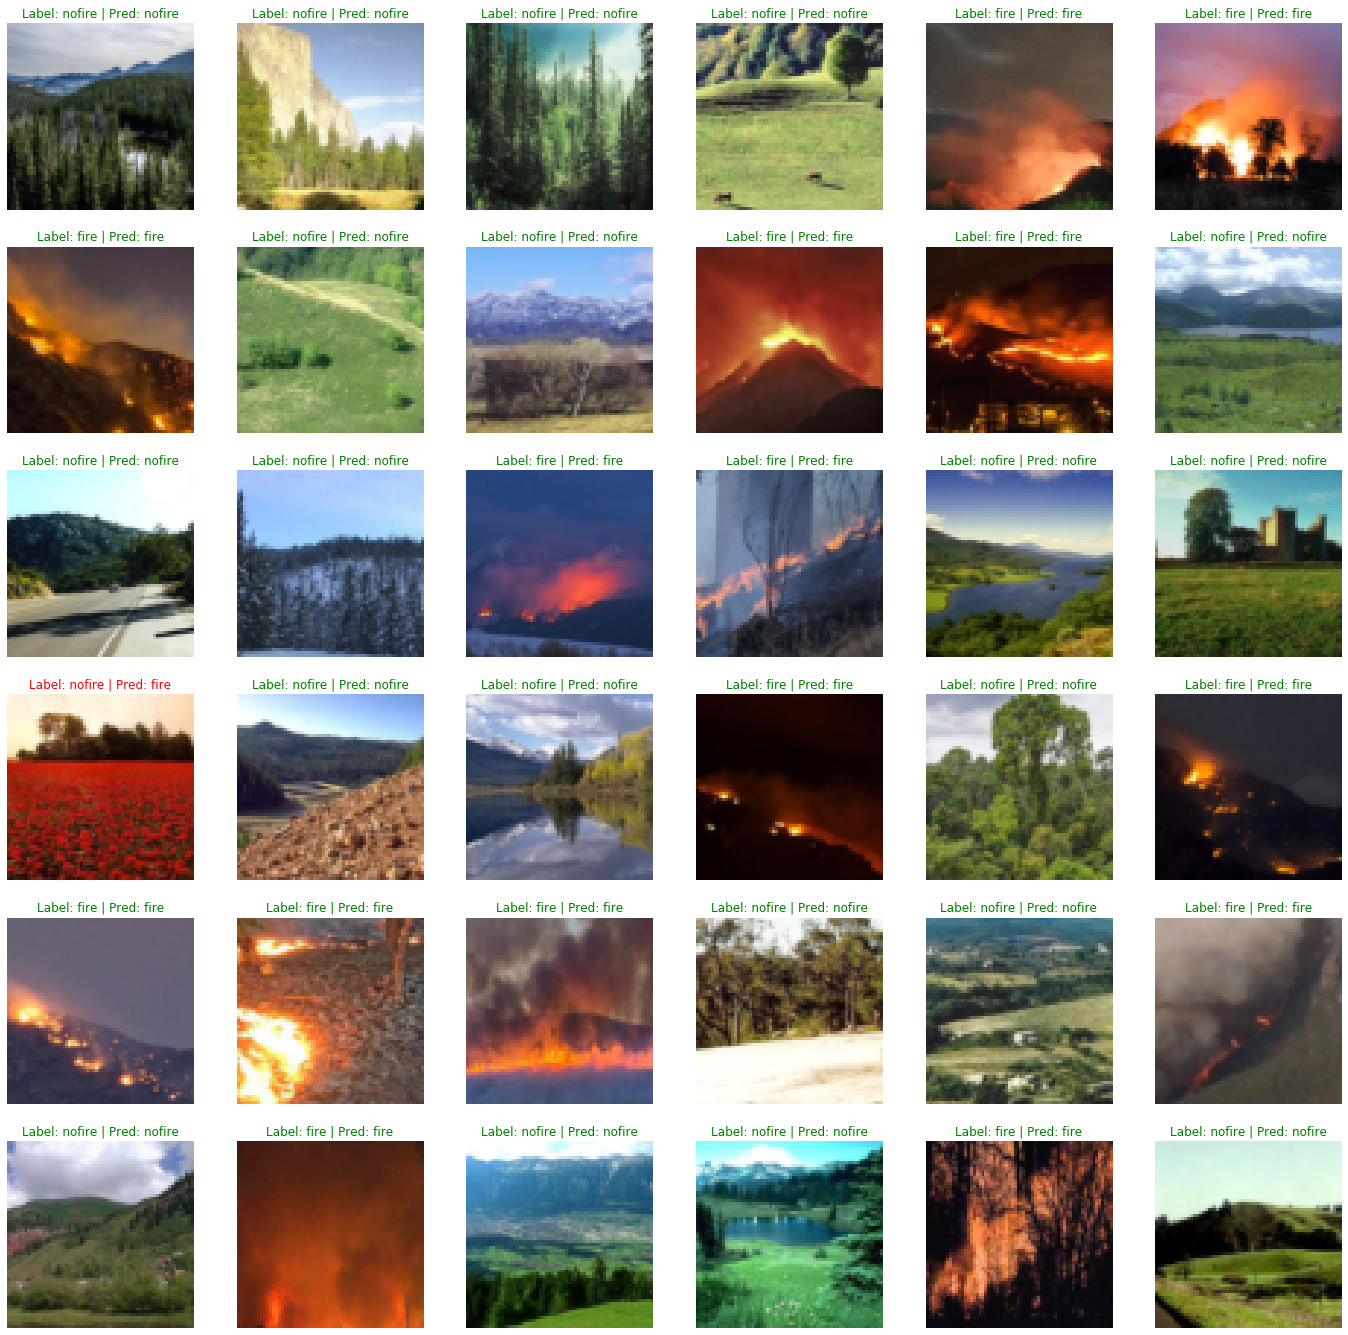

In [17]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    font = {'color':'r'} if label != pred else {'color':'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'Label: {label} | Pred: {pred}', fontdict=font);
    ax.axis('off');